# Tweet Signal Exploration

Sentiment scoring (VADER, FinBERT) failed — Elon's tweets are almost always positive about Tesla regardless of stock direction.  
Instead, we explore **behavioral signals**: engagement, timing, silence, topics, and word-level analysis.

| # | Approach | Question |
|---|----------|----------|
| 1 | Engagement metrics | Do viral tweets (high likes/views) precede moves? |
| 2 | Silence signal | Does Elon going quiet about Tesla predict anything? |
| 3 | Timing patterns | Does when he tweets (pre-market, weekend) matter? |
| 4 | Topic classification | Do certain topics (FSD, production, earnings) move the stock differently? |
| 5 | Word-level analysis | Which specific words predict TSLA direction? |
| 6 | Stock reaction analysis | What actually happens to TSLA in the hours/days after a tweet? |
| 7 | Tweet frequency regimes | Does tweeting a lot vs a little signal anything? |

**Key finding:** Word-level analysis on ALL tweets (not just Tesla-related) provides the strongest signal.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.helpers import DATA_RAW, DATA_PROCESSED, DATA_EXTERNAL

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load raw tweets with ALL metadata
tweets_raw = pd.read_csv(DATA_EXTERNAL / 'elonmusk_tweets.csv', low_memory=False)

# Parse dates with timezone (Elon tweets from US timezones)
tweets_raw['dt'] = pd.to_datetime(tweets_raw['createdAt'], utc=True, errors='coerce')
tweets_raw['date'] = tweets_raw['dt'].dt.tz_localize(None).dt.normalize()
tweets_raw['hour_utc'] = tweets_raw['dt'].dt.hour
# Convert to US Pacific (Elon is usually in CA/TX)
tweets_raw['dt_pacific'] = tweets_raw['dt'].dt.tz_convert('US/Pacific')
tweets_raw['hour_pacific'] = tweets_raw['dt_pacific'].dt.hour

# Clean boolean columns
for col in ['isReply', 'isRetweet', 'isQuote']:
    tweets_raw[col] = tweets_raw[col].astype(str).str.lower().isin(['true', '1'])

# Clean engagement columns
for col in ['likeCount', 'retweetCount', 'viewCount', 'quoteCount', 'replyCount', 'bookmarkCount']:
    tweets_raw[col] = pd.to_numeric(tweets_raw[col], errors='coerce')

# Load TSLA price data
tsla = pd.read_csv(DATA_RAW / 'tsla_ohlcv.csv', index_col='Date', parse_dates=True)
tsla['daily_return'] = tsla['Close'].pct_change()
tsla['next_day_return'] = tsla['daily_return'].shift(-1)
tsla['target'] = tsla['target'].astype(int)

# Filter to originals only (no replies, no retweets)
originals = tweets_raw[~tweets_raw['isReply'] & ~tweets_raw['isRetweet']].copy()

# Tesla-related filter
TESLA_KEYWORDS = ['tesla', 'tsla', 'fsd', 'cybertruck', 'robotaxi',
                  'deliveries', 'model y', 'model 3', 'model s', 'model x',
                  'autopilot', 'gigafactory', 'supercharger', 'megapack',
                  'powerwall', 'full self driving', 'self driving']
text_lower = originals['fullText'].str.lower()
tesla_mask = pd.Series(False, index=originals.index)
for kw in TESLA_KEYWORDS:
    tesla_mask |= text_lower.str.contains(kw, na=False)
tesla_originals = originals[tesla_mask].copy()

print(f'All tweets: {len(tweets_raw)}')
print(f'Originals (no replies/retweets): {len(originals)}')
print(f'Tesla originals: {len(tesla_originals)}')
print(f'ALL originals (including non-Tesla): {len(originals)}')
print(f'TSLA trading days: {len(tsla)}')
print(f'Baseline P(Up): {tsla["target"].mean():.3f}')

All tweets: 55099
Originals (no replies/retweets): 14911
Tesla originals: 1364
ALL originals (including non-Tesla): 14911
TSLA trading days: 3935
Baseline P(Up): 0.516


## 1. Engagement Metrics

Hypothesis: viral tweets (high likes, views, retweets) = market attention = stock movement.  
We don't care about sentiment — just how much attention the tweet got.

=== P(Up) by Tweet Activity ===
  No Tesla tweet:    P(Up) = 0.515  (n=3250)
  Has Tesla tweet:   P(Up) = 0.520  (n=685)
  Baseline:          P(Up) = 0.516

=== P(Up) by Engagement Level (likes quartiles) ===
  Q1 (low)       : P(Up) = 0.552  (n=172, likes=0-2151)
  Q2             : P(Up) = 0.538  (n=171, likes=2171-22369)
  Q3             : P(Up) = 0.485  (n=171, likes=22380-80016)
  Q4 (viral)     : P(Up) = 0.503  (n=171, likes=80111-959864)

=== P(Up) by View Count (quartiles) ===
  Q1 (low)       : P(Up) = 0.529  (n=172, views=0-0)
  Q2             : P(Up) = 0.515  (n=171, views=0-0)
  Q3             : P(Up) = 0.556  (n=171, views=0-0)
  Q4 (viral)     : P(Up) = 0.480  (n=171, views=0-250793477)


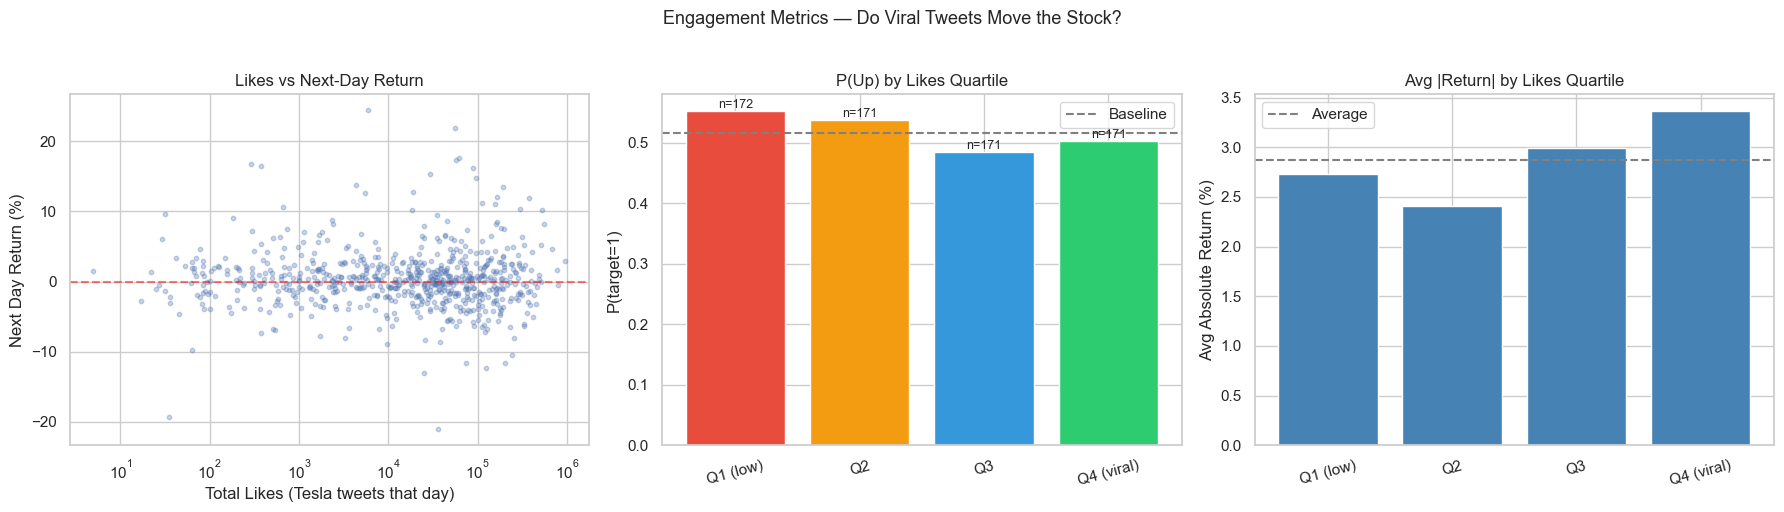

In [3]:
# Daily engagement aggregation (Tesla tweets only)
eng_daily = tesla_originals.groupby('date').agg(
    tweet_count=('fullText', 'count'),
    total_likes=('likeCount', 'sum'),
    max_likes=('likeCount', 'max'),
    total_retweets=('retweetCount', 'sum'),
    total_views=('viewCount', 'sum'),
    max_views=('viewCount', 'max'),
    total_replies=('replyCount', 'sum'),
).rename_axis('Date')

# Merge with stock data
eng = tsla[['target', 'daily_return', 'next_day_return', 'Close', 'Volume']].join(eng_daily, how='left')
eng['has_tesla_tweet'] = eng['tweet_count'].notna() & (eng['tweet_count'] > 0)
eng['tweet_count'] = eng['tweet_count'].fillna(0)

# Compare days with vs without Tesla tweets
print('=== P(Up) by Tweet Activity ===')
print(f'  No Tesla tweet:    P(Up) = {eng.loc[~eng["has_tesla_tweet"], "target"].mean():.3f}  (n={len(eng[~eng["has_tesla_tweet"]])})')
print(f'  Has Tesla tweet:   P(Up) = {eng.loc[eng["has_tesla_tweet"], "target"].mean():.3f}  (n={len(eng[eng["has_tesla_tweet"]])})')
print(f'  Baseline:          P(Up) = {eng["target"].mean():.3f}')
print()

# Engagement percentile buckets (use rank-based percentiles to handle ties)
tweet_days = eng[eng['has_tesla_tweet']].copy()
tweet_days['likes_rank'] = tweet_days['total_likes'].rank(method='first')
tweet_days['likes_pct'] = pd.qcut(tweet_days['likes_rank'], q=4,
                                   labels=['Q1 (low)', 'Q2', 'Q3', 'Q4 (viral)'])

print('=== P(Up) by Engagement Level (likes quartiles) ===')
for q in ['Q1 (low)', 'Q2', 'Q3', 'Q4 (viral)']:
    sub = tweet_days[tweet_days['likes_pct'] == q]
    if len(sub) > 0:
        like_range = f'{sub["total_likes"].min():.0f}-{sub["total_likes"].max():.0f}'
        print(f'  {q:15s}: P(Up) = {sub["target"].mean():.3f}  (n={len(sub)}, likes={like_range})')

# Views quartiles (only available for newer tweets)
tweet_days_views = tweet_days.dropna(subset=['total_views'])
if len(tweet_days_views) > 20:
    tweet_days_views = tweet_days_views.copy()
    tweet_days_views['views_rank'] = tweet_days_views['total_views'].rank(method='first')
    tweet_days_views['views_pct'] = pd.qcut(tweet_days_views['views_rank'], q=4,
                                             labels=['Q1 (low)', 'Q2', 'Q3', 'Q4 (viral)'])
    print()
    print('=== P(Up) by View Count (quartiles) ===')
    for q in ['Q1 (low)', 'Q2', 'Q3', 'Q4 (viral)']:
        sub = tweet_days_views[tweet_days_views['views_pct'] == q]
        if len(sub) > 0:
            print(f'  {q:15s}: P(Up) = {sub["target"].mean():.3f}  (n={len(sub)}, views={sub["total_views"].min():.0f}-{sub["total_views"].max():.0f})')

# Visualize engagement vs next-day return
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Likes vs next-day return
td = tweet_days.dropna(subset=['next_day_return', 'total_likes'])
axes[0].scatter(td['total_likes'], td['next_day_return'] * 100, alpha=0.3, s=10)
axes[0].axhline(0, color='red', ls='--', alpha=0.5)
axes[0].set_xlabel('Total Likes (Tesla tweets that day)')
axes[0].set_ylabel('Next Day Return (%)')
axes[0].set_title('Likes vs Next-Day Return')
axes[0].set_xscale('log')

# 2. P(Up) by engagement bucket (bar chart)
rates = tweet_days.groupby('likes_pct', observed=True)['target'].agg(['mean', 'count'])
bars = axes[1].bar(range(len(rates)), rates['mean'], color=['#e74c3c', '#f39c12', '#3498db', '#2ecc71'])
for i, (bar, count) in enumerate(zip(bars, rates['count'])):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'n={int(count)}', ha='center', fontsize=9)
axes[1].set_xticks(range(len(rates)))
axes[1].set_xticklabels(rates.index, rotation=15)
axes[1].axhline(eng['target'].mean(), ls='--', color='gray', label='Baseline')
axes[1].set_title('P(Up) by Likes Quartile')
axes[1].set_ylabel('P(target=1)')
axes[1].legend()

# 3. Average absolute return by engagement
td['abs_return'] = td['next_day_return'].abs()
abs_by_q = td.groupby('likes_pct', observed=True)['abs_return'].mean() * 100
axes[2].bar(range(len(abs_by_q)), abs_by_q.values, color='steelblue')
axes[2].set_xticks(range(len(abs_by_q)))
axes[2].set_xticklabels(abs_by_q.index, rotation=15)
axes[2].axhline(td['abs_return'].mean() * 100, ls='--', color='gray', label='Average')
axes[2].set_title('Avg |Return| by Likes Quartile')
axes[2].set_ylabel('Avg Absolute Return (%)')
axes[2].legend()

plt.suptitle('Engagement Metrics — Do Viral Tweets Move the Stock?', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## 2. Silence Signal

Hypothesis: when Elon goes quiet about Tesla (or goes quiet entirely), something may be brewing.  
We measure gaps between Tesla tweets and between ALL tweets.

=== P(Up) by Days Since Last Tesla Tweet ===
  Same day       : P(Up) = 0.549  (n=370)
  1-3 days       : P(Up) = 0.509  (n=379)
  4-7 days       : P(Up) = 0.519  (n=775)
  8-14 days      : P(Up) = 0.494  (n=593)
  15-30 days     : P(Up) = 0.539  (n=460)
  30+ days       : P(Up) = 0.503  (n=312)
  Baseline:        P(Up) = 0.518

=== P(Up) by 30-day Tesla Tweet Frequency ===
  Q1 (quiet)     : P(Up) = 0.487  (n=977, tweets/30d: 0-3)
  Q2             : P(Up) = 0.528  (n=976, tweets/30d: 3-6)
  Q3             : P(Up) = 0.528  (n=976, tweets/30d: 6-11)
  Q4 (active)    : P(Up) = 0.523  (n=977, tweets/30d: 11-34)


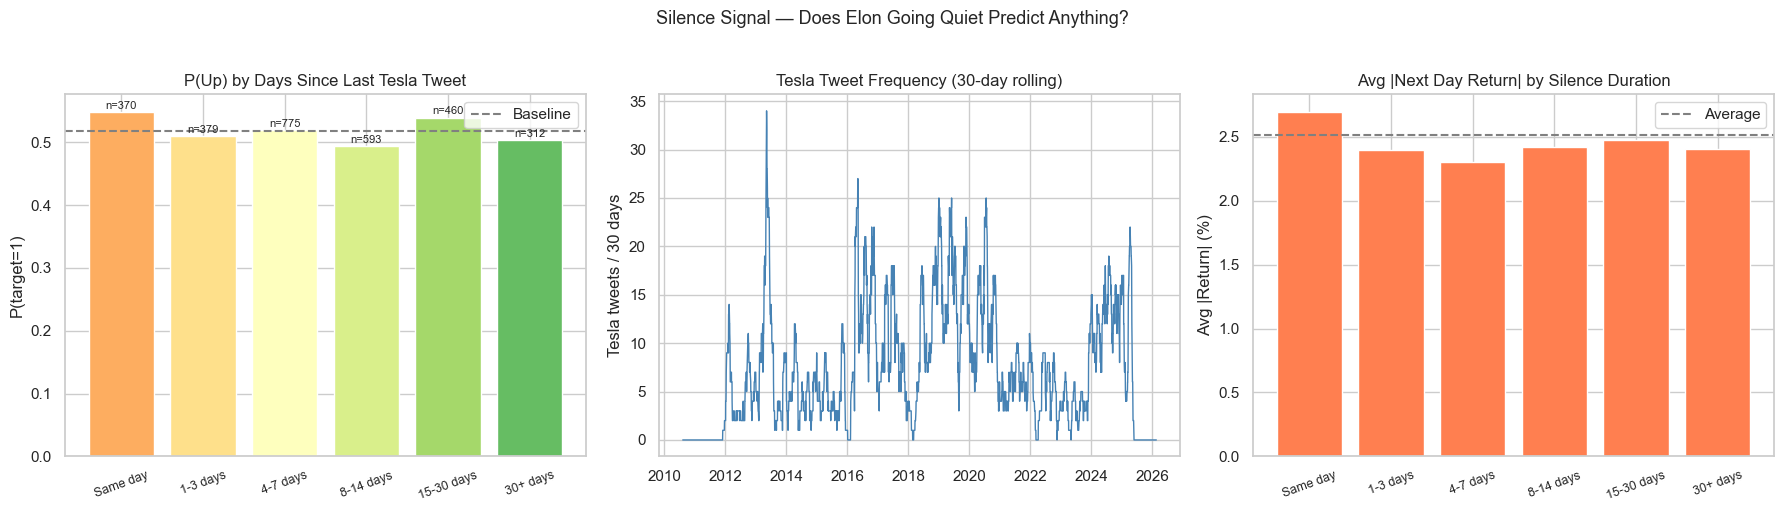

In [4]:
# Count ALL original tweets per day (not just Tesla)
all_daily = originals.groupby('date').agg(
    all_tweet_count=('fullText', 'count'),
).rename_axis('Date')

# Tesla tweets per day
tesla_daily = tesla_originals.groupby('date').agg(
    tesla_tweet_count=('fullText', 'count'),
).rename_axis('Date')

silence = tsla[['target', 'daily_return', 'next_day_return']].copy()
silence = silence.join(all_daily, how='left').join(tesla_daily, how='left')
silence['all_tweet_count'] = silence['all_tweet_count'].fillna(0)
silence['tesla_tweet_count'] = silence['tesla_tweet_count'].fillna(0)

# Days since last Tesla tweet
tesla_tweet_dates = silence.index[silence['tesla_tweet_count'] > 0]
silence['days_since_tesla_tweet'] = np.nan
for td in tesla_tweet_dates:
    mask = silence.index >= td
    silence.loc[mask, 'days_since_tesla_tweet'] = (silence.index[mask] - td).days

# Days since last ANY tweet
any_tweet_dates = silence.index[silence['all_tweet_count'] > 0]
silence['days_since_any_tweet'] = np.nan
for td in any_tweet_dates:
    mask = silence.index >= td
    silence.loc[mask, 'days_since_any_tweet'] = (silence.index[mask] - td).days

# Rolling tweet frequency (7-day and 30-day)
silence['tesla_freq_7d'] = silence['tesla_tweet_count'].rolling(7).sum()
silence['tesla_freq_30d'] = silence['tesla_tweet_count'].rolling(30).sum()
silence['all_freq_7d'] = silence['all_tweet_count'].rolling(7).sum()

# Analyze silence periods
valid = silence.dropna(subset=['days_since_tesla_tweet', 'target']).copy()

print('=== P(Up) by Days Since Last Tesla Tweet ===')
bins = [0, 1, 3, 7, 14, 30, 999]
labels = ['Same day', '1-3 days', '4-7 days', '8-14 days', '15-30 days', '30+ days']
valid['silence_bucket'] = pd.cut(valid['days_since_tesla_tweet'], bins=bins, labels=labels)
for label in labels:
    sub = valid[valid['silence_bucket'] == label]
    if len(sub) > 10:
        print(f'  {label:15s}: P(Up) = {sub["target"].mean():.3f}  (n={len(sub)})')

print(f'  Baseline:        P(Up) = {valid["target"].mean():.3f}')
print()

# 30-day Tesla tweet frequency vs target
print('=== P(Up) by 30-day Tesla Tweet Frequency ===')
valid2 = silence.dropna(subset=['tesla_freq_30d', 'target']).copy()
valid2['freq_rank'] = valid2['tesla_freq_30d'].rank(method='first')
freq_labels = pd.qcut(valid2['freq_rank'], q=4, labels=['Q1 (quiet)', 'Q2', 'Q3', 'Q4 (active)'])
for q in ['Q1 (quiet)', 'Q2', 'Q3', 'Q4 (active)']:
    sub = valid2[freq_labels == q]
    if len(sub) > 10:
        print(f'  {q:15s}: P(Up) = {sub["target"].mean():.3f}  (n={len(sub)}, tweets/30d: {sub["tesla_freq_30d"].min():.0f}-{sub["tesla_freq_30d"].max():.0f})')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. P(Up) by silence duration
rates = valid.groupby('silence_bucket', observed=True)['target'].agg(['mean', 'count'])
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.8, len(rates)))
bars = axes[0].bar(range(len(rates)), rates['mean'], color=colors)
for i, (bar, count) in enumerate(zip(bars, rates['count'])):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'n={int(count)}', ha='center', fontsize=8)
axes[0].set_xticks(range(len(rates)))
axes[0].set_xticklabels(rates.index, rotation=20, fontsize=9)
axes[0].axhline(valid['target'].mean(), ls='--', color='gray', label='Baseline')
axes[0].set_title('P(Up) by Days Since Last Tesla Tweet')
axes[0].set_ylabel('P(target=1)')
axes[0].legend()

# 2. Tesla tweet frequency over time
axes[1].plot(silence.index, silence['tesla_freq_30d'], color='steelblue', linewidth=1)
axes[1].set_title('Tesla Tweet Frequency (30-day rolling)')
axes[1].set_ylabel('Tesla tweets / 30 days')

# 3. Average absolute return by silence duration
valid['abs_next'] = valid['next_day_return'].abs()
abs_rates = valid.groupby('silence_bucket', observed=True)['abs_next'].mean() * 100
axes[2].bar(range(len(abs_rates)), abs_rates.values, color='coral')
axes[2].set_xticks(range(len(abs_rates)))
axes[2].set_xticklabels(abs_rates.index, rotation=20, fontsize=9)
axes[2].axhline(valid['abs_next'].mean() * 100, ls='--', color='gray', label='Average')
axes[2].set_title('Avg |Next Day Return| by Silence Duration')
axes[2].set_ylabel('Avg |Return| (%)')
axes[2].legend()

plt.suptitle('Silence Signal — Does Elon Going Quiet Predict Anything?', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## 3. Timing Patterns

Hypothesis: pre-market tweets, after-hours tweets, and weekend tweets may signal different things.  
US market hours: 9:30 AM - 4:00 PM ET = 6:30 AM - 1:00 PM PT.

=== Tweet Session Distribution ===
session
market_hours    382
weekend         356
evening         265
after_hours     258
overnight        92
pre_market       11
Name: count, dtype: int64

=== P(Up) on Days Following Session-Specific Tweets ===
  market_hours   : P(Up) = 0.562  (n=274)
  after_hours    : P(Up) = 0.558  (n=208)
  evening        : P(Up) = 0.514  (n=218)
  overnight      : P(Up) = 0.570  (n=79)
  weekend        : P(Up) = 0.514  (n=214)
  Baseline:        P(Up) = 0.516


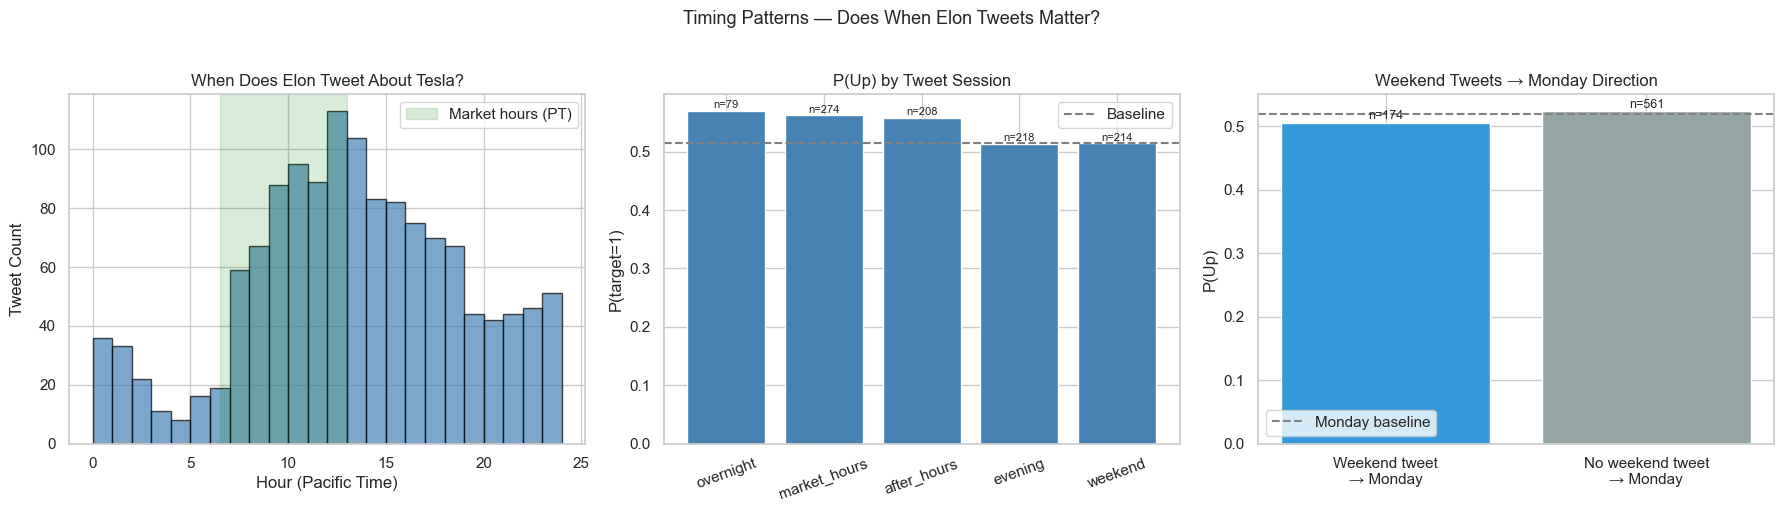

In [5]:
# Classify tweet timing (Pacific time, where Elon usually is)
tesla_timed = tesla_originals.copy()
tesla_timed['hour_pt'] = tesla_timed['dt_pacific'].dt.hour
tesla_timed['day_of_week'] = tesla_timed['dt_pacific'].dt.dayofweek  # 0=Mon, 6=Sun
tesla_timed['is_weekend'] = tesla_timed['day_of_week'] >= 5

# Market session classification (Pacific time)
def classify_session(row):
    h = row['hour_pt']
    if row['is_weekend']:
        return 'weekend'
    elif h < 6:  # before 6 AM PT = before pre-market
        return 'overnight'
    elif h < 7:  # 6-6:30 AM PT ~= pre-market
        return 'pre_market'
    elif h < 13:  # 6:30 AM - 1 PM PT = market hours
        return 'market_hours'
    elif h < 17:  # 1-5 PM PT = after hours
        return 'after_hours'
    else:  # 5 PM+ PT = evening
        return 'evening'

tesla_timed['session'] = tesla_timed.apply(classify_session, axis=1)

# For weekend tweets, assign to next trading day
tesla_timed['trading_date'] = tesla_timed['date']
# Find next trading day for weekend tweets
trading_days = set(tsla.index)
def next_trading_day(dt):
    d = dt
    for _ in range(5):  # max 5 days ahead
        d = d + pd.Timedelta(days=1)
        if d in trading_days:
            return d
    return dt  # fallback

weekend_mask = tesla_timed['is_weekend']
tesla_timed.loc[weekend_mask, 'trading_date'] = tesla_timed.loc[weekend_mask, 'date'].apply(next_trading_day)
# Also shift after-hours/evening tweets to next trading day
late_mask = tesla_timed['session'].isin(['after_hours', 'evening']) & ~tesla_timed['is_weekend']
tesla_timed.loc[late_mask, 'trading_date'] = tesla_timed.loc[late_mask, 'date'].apply(next_trading_day)

# Aggregate by session and trading date
session_daily = tesla_timed.groupby(['trading_date', 'session']).agg(
    count=('fullText', 'count'),
    total_likes=('likeCount', 'sum'),
).reset_index()

# Pivot: one column per session
session_pivot = session_daily.pivot_table(index='trading_date', columns='session',
                                          values='count', fill_value=0)
session_pivot.index.name = 'Date'

timing = tsla[['target', 'next_day_return']].join(session_pivot, how='left').fillna(0)

print('=== Tweet Session Distribution ===')
print(tesla_timed['session'].value_counts())
print()

# P(Up) by session type
print('=== P(Up) on Days Following Session-Specific Tweets ===')
for session in ['pre_market', 'market_hours', 'after_hours', 'evening', 'overnight', 'weekend']:
    if session in timing.columns:
        has_session = timing[timing[session] > 0]
        if len(has_session) > 10:
            print(f'  {session:15s}: P(Up) = {has_session["target"].mean():.3f}  (n={len(has_session)})')
print(f'  Baseline:        P(Up) = {timing["target"].mean():.3f}')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Hour distribution of Tesla tweets
axes[0].hist(tesla_timed['hour_pt'], bins=24, range=(0, 24), edgecolor='black', color='steelblue', alpha=0.7)
axes[0].axvspan(6.5, 13, alpha=0.15, color='green', label='Market hours (PT)')
axes[0].set_xlabel('Hour (Pacific Time)')
axes[0].set_ylabel('Tweet Count')
axes[0].set_title('When Does Elon Tweet About Tesla?')
axes[0].legend()

# 2. P(Up) by session
sessions_order = ['overnight', 'pre_market', 'market_hours', 'after_hours', 'evening', 'weekend']
session_rates = []
session_counts = []
session_labels = []
for s in sessions_order:
    if s in timing.columns:
        sub = timing[timing[s] > 0]
        if len(sub) > 10:
            session_rates.append(sub['target'].mean())
            session_counts.append(len(sub))
            session_labels.append(s)

bars = axes[1].bar(range(len(session_rates)), session_rates, color='steelblue')
for i, (bar, n) in enumerate(zip(bars, session_counts)):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'n={n}', ha='center', fontsize=8)
axes[1].set_xticks(range(len(session_labels)))
axes[1].set_xticklabels(session_labels, rotation=20)
axes[1].axhline(timing['target'].mean(), ls='--', color='gray', label='Baseline')
axes[1].set_title('P(Up) by Tweet Session')
axes[1].set_ylabel('P(target=1)')
axes[1].legend()

# 3. Weekend tweets — do they predict Monday?
has_weekend = timing[timing.get('weekend', pd.Series(0)) > 0] if 'weekend' in timing.columns else pd.DataFrame()
no_weekend = timing[timing.get('weekend', pd.Series(0)) == 0] if 'weekend' in timing.columns else pd.DataFrame()
if len(has_weekend) > 10:
    categories = ['Weekend tweet\n→ Monday', 'No weekend tweet\n→ Monday']
    # Filter to Mondays only for fair comparison
    mondays = timing[timing.index.dayofweek == 0]
    mon_tweet = mondays[mondays.get('weekend', 0) > 0]
    mon_no_tweet = mondays[mondays.get('weekend', 0) == 0]
    vals = [mon_tweet['target'].mean() if len(mon_tweet) > 0 else 0,
            mon_no_tweet['target'].mean() if len(mon_no_tweet) > 0 else 0]
    counts = [len(mon_tweet), len(mon_no_tweet)]
    bars = axes[2].bar(categories, vals, color=['#3498db', '#95a5a6'])
    for bar, n in zip(bars, counts):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                     f'n={n}', ha='center', fontsize=9)
    axes[2].axhline(mondays['target'].mean(), ls='--', color='gray', label='Monday baseline')
    axes[2].set_title('Weekend Tweets → Monday Direction')
    axes[2].set_ylabel('P(Up)')
    axes[2].legend()
else:
    axes[2].text(0.5, 0.5, 'Insufficient weekend tweet data', ha='center', va='center', transform=axes[2].transAxes)

plt.suptitle('Timing Patterns — Does When Elon Tweets Matter?', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## 4. Topic Classification

Instead of positive/negative, classify tweets by WHAT Elon is talking about.  
Different topics may have different stock impacts.

In [6]:
# Rule-based topic classification using keyword groups
TOPIC_KEYWORDS = {
    'production': ['deliveries', 'production', 'manufactured', 'factory', 'giga', 'output',
                   'production line', 'ramp', 'produced', 'built'],
    'fsd_autonomy': ['fsd', 'full self driving', 'self driving', 'autopilot', 'autosteer',
                     'robotaxi', 'autonomous', 'driverless'],
    'product_launch': ['cybertruck', 'model 2', 'model y', 'model 3', 'model s', 'model x',
                       'unveil', 'launch', 'new model', 'refresh', 'plaid'],
    'financial': ['earnings', 'revenue', 'profit', 'margin', 'cash flow', 'quarter', 'q1', 'q2',
                  'q3', 'q4', 'investor', 'shareholder', 'stock', 'tsla'],
    'energy': ['solar', 'powerwall', 'megapack', 'supercharger', 'energy', 'battery',
               'charging', '4680'],
    'safety': ['crash', 'accident', 'safe', 'safety', 'recall', 'nhtsa', 'investigation'],
    'ai_robot': ['optimus', 'robot', 'ai day', 'dojo', 'neural', 'training', 'ai '],
}

tesla_topics = tesla_originals.copy()
text_lower = tesla_topics['fullText'].str.lower()

for topic, keywords in TOPIC_KEYWORDS.items():
    topic_mask = pd.Series(False, index=tesla_topics.index)
    for kw in keywords:
        topic_mask |= text_lower.str.contains(kw, na=False)
    tesla_topics[f'topic_{topic}'] = topic_mask

# Assign primary topic (first match, or 'general' if none)
topic_cols = [c for c in tesla_topics.columns if c.startswith('topic_')]
def get_primary_topic(row):
    for tc in topic_cols:
        if row[tc]:
            return tc.replace('topic_', '')
    return 'general'

tesla_topics['primary_topic'] = tesla_topics.apply(get_primary_topic, axis=1)

print('=== Topic Distribution ===')
print(tesla_topics['primary_topic'].value_counts())
print()

# Aggregate by trading date and topic
topic_daily = tesla_topics.groupby('date').agg(
    primary_topic=('primary_topic', lambda x: x.mode().iloc[0] if len(x) > 0 else 'general'),
    n_topics=('primary_topic', 'nunique'),
    **{tc: (tc, 'any') for tc in topic_cols},
).rename_axis('Date')

topic_merged = tsla[['target', 'next_day_return']].join(topic_daily, how='inner')

print('=== P(Up) by Dominant Tweet Topic ===')
for topic in tesla_topics['primary_topic'].value_counts().index:
    sub = topic_merged[topic_merged['primary_topic'] == topic]
    if len(sub) >= 10:
        avg_ret = sub['next_day_return'].mean() * 100
        print(f'  {topic:20s}: P(Up) = {sub["target"].mean():.3f}  (n={len(sub)}, avg next-day return: {avg_ret:+.2f}%)')
print(f'  {"Baseline":20s}: P(Up) = {tsla["target"].mean():.3f}')

=== Topic Distribution ===
primary_topic
general           626
product_launch    318
production        117
energy            106
fsd_autonomy      105
financial          49
ai_robot           30
safety             13
Name: count, dtype: int64

=== P(Up) by Dominant Tweet Topic ===
  general             : P(Up) = 0.552  (n=319, avg next-day return: +0.68%)
  product_launch      : P(Up) = 0.500  (n=150, avg next-day return: +0.07%)
  production          : P(Up) = 0.400  (n=50, avg next-day return: -0.01%)
  energy              : P(Up) = 0.444  (n=63, avg next-day return: -0.52%)
  fsd_autonomy        : P(Up) = 0.519  (n=52, avg next-day return: -0.19%)
  financial           : P(Up) = 0.667  (n=27, avg next-day return: +1.74%)
  ai_robot            : P(Up) = 0.474  (n=19, avg next-day return: +0.32%)
  Baseline            : P(Up) = 0.516


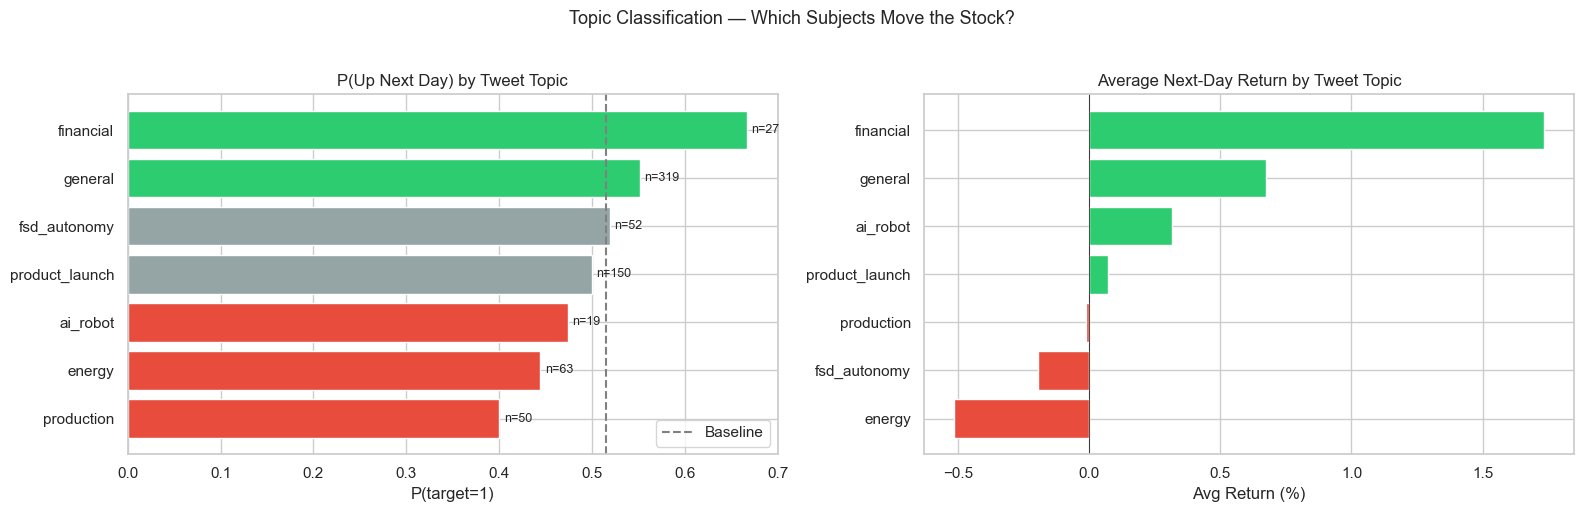

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# P(Up) by topic
topic_rates = topic_merged.groupby('primary_topic')['target'].agg(['mean', 'count'])
topic_rates = topic_rates[topic_rates['count'] >= 10].sort_values('mean')
colors = ['#e74c3c' if v < tsla['target'].mean() - 0.02 else '#2ecc71' if v > tsla['target'].mean() + 0.02 else '#95a5a6' for v in topic_rates['mean']]
bars = axes[0].barh(range(len(topic_rates)), topic_rates['mean'], color=colors)
axes[0].set_yticks(range(len(topic_rates)))
axes[0].set_yticklabels(topic_rates.index)
for i, (bar, count) in enumerate(zip(bars, topic_rates['count'])):
    axes[0].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                 f'n={int(count)}', va='center', fontsize=9)
axes[0].axvline(tsla['target'].mean(), ls='--', color='gray', label='Baseline')
axes[0].set_title('P(Up Next Day) by Tweet Topic')
axes[0].set_xlabel('P(target=1)')
axes[0].legend()

# Average return by topic
topic_returns = topic_merged.groupby('primary_topic')['next_day_return'].agg(['mean', 'count'])
topic_returns = topic_returns[topic_returns['count'] >= 10].sort_values('mean')
colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in topic_returns['mean']]
axes[1].barh(range(len(topic_returns)), topic_returns['mean'] * 100, color=colors)
axes[1].set_yticks(range(len(topic_returns)))
axes[1].set_yticklabels(topic_returns.index)
axes[1].axvline(0, color='black', linewidth=0.5)
axes[1].set_title('Average Next-Day Return by Tweet Topic')
axes[1].set_xlabel('Avg Return (%)')

plt.suptitle('Topic Classification — Which Subjects Move the Stock?', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## 5. Word-Level Analysis — ALL Tweets

Raw word clouds are misleading — Elon says similar things regardless of stock direction.  
Instead we use **log-odds ratio with informative Dirichlet prior** (Monroe et al. 2008) to find words that are *statistically overrepresented* before up days vs down days.

**Critical insight:** The Tesla keyword filter drops us from 14,911 originals to 1,364 — losing 91% of the data.  
But Elon IS Tesla. His tweets about politics, SpaceX, memes, personal rants — all of it could signal something about TSLA.  
Using ALL 14,911 original tweets gives 10x more data and far more statistical power.

ALL original tweets matched to trading days: 10416
Unique trading days covered: 2016

Trading days with tweets — total: 2016, train only: 1702
Word analysis uses data up to: 2023-12-29 (no leakage from test period)

Up-day tweets (train): 906 days  |  Down-day tweets (train): 796 days
Unique words: 7172

Words analyzed (|z| > 1.0): 146
Words with |z| > 1.5: 54
  p < 0.05: 12
  p < 0.10: 21


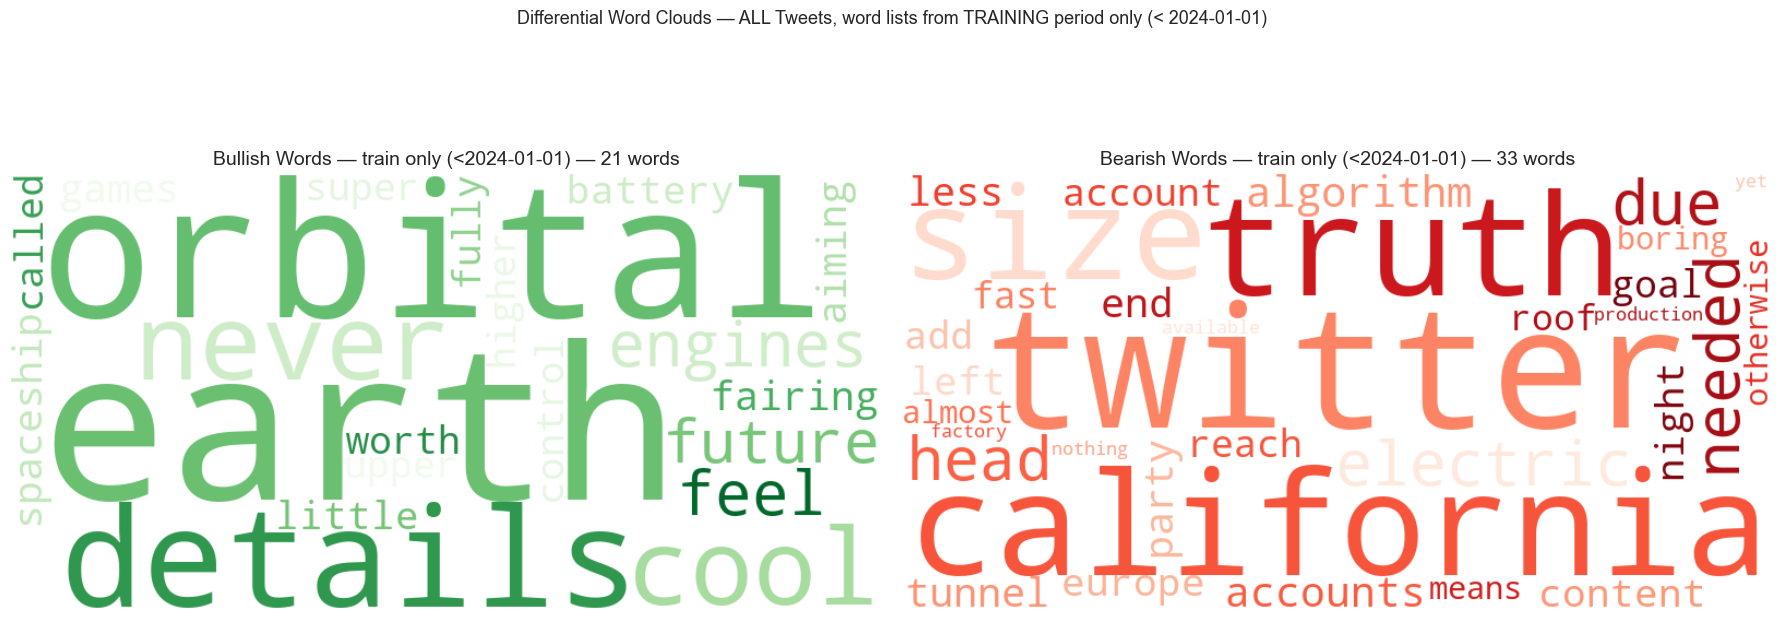

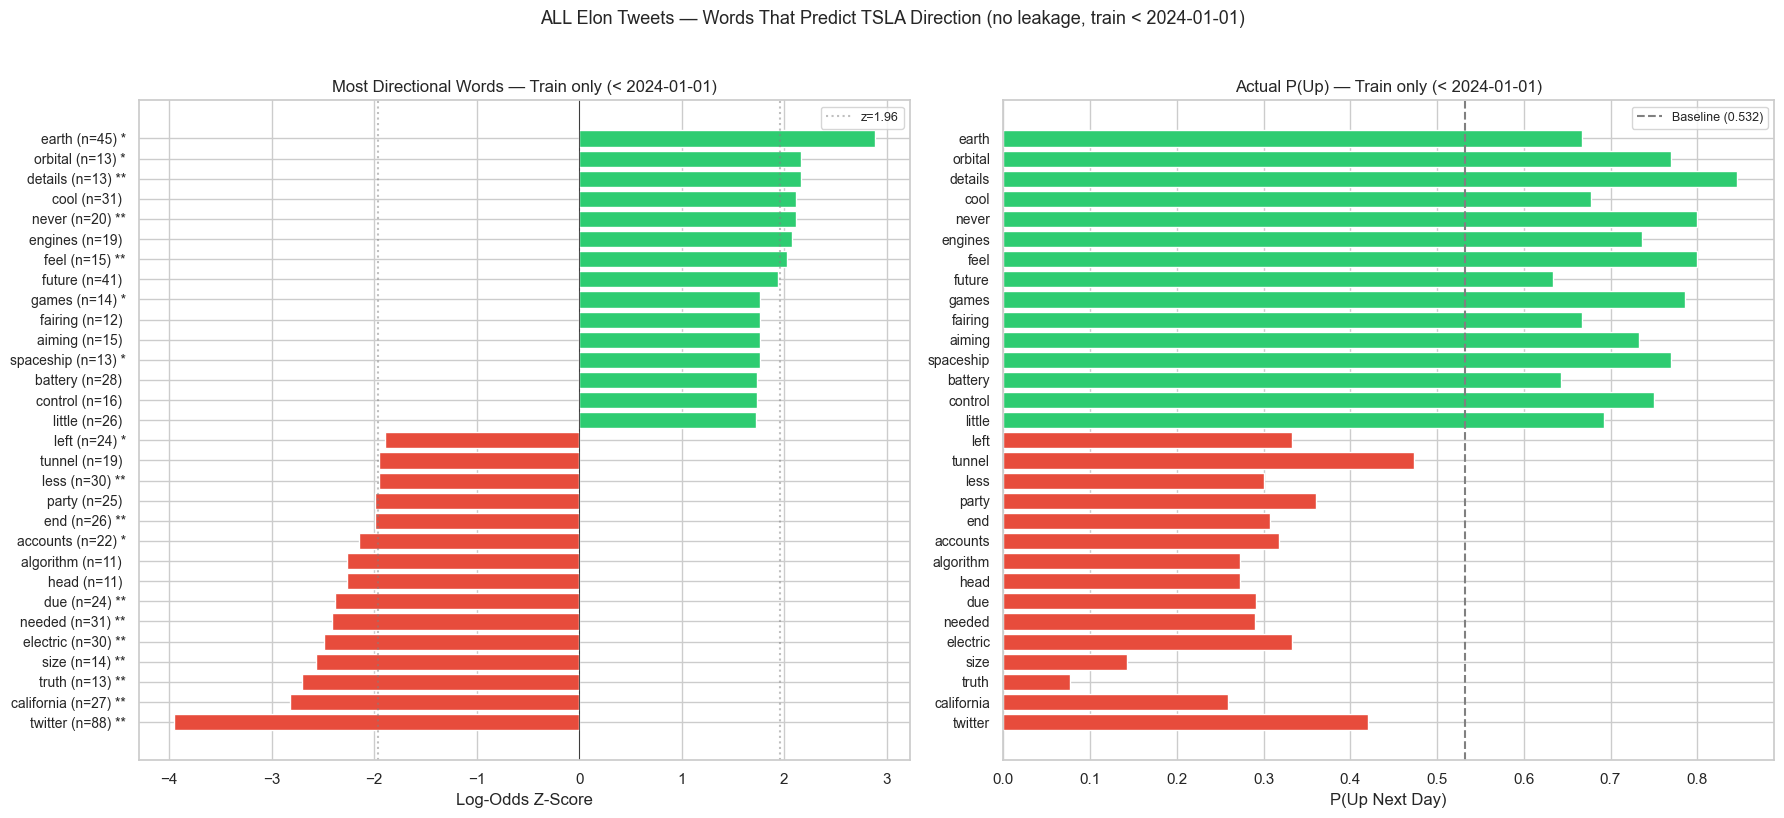

In [8]:
from wordcloud import WordCloud
from collections import Counter
from scipy.stats import fisher_exact
import re

TRAIN_CUTOFF = '2024-01-01'  # word lists derived from training period ONLY (no leakage)

# --- Merge tweets with next-day stock direction ---
tweet_words = tesla_originals[['date', 'fullText']].copy()
tweet_words.columns = ['date', 'text']
tweet_words = tweet_words.merge(
    tsla[['target', 'next_day_return']].reset_index(),
    left_on='date', right_on='Date', how='inner'
).dropna(subset=['target'])

# --- Clean text ---
def clean_text(text):
    text = re.sub(r'http\S+', '', str(text))
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower().strip()

tweet_words['clean'] = tweet_words['text'].apply(clean_text)

# --- Comprehensive stopword set ---
STOP = set("""
i me my myself we our ours ourselves you your yours yourself yourselves he him his himself
she her hers herself it its itself they them their theirs themselves what which who whom this
that these those am is are was were be been being have has had having do does did doing a an
the and but if or because as until while of at by for with about against between through during
before after above below to from up down in out on off over under again further then once here
there when where why how all both each few more most other some such no nor not only own same
so than too very s t can will just don should now d ll m o re ve y ain aren couldn didn doesn
hadn hasn haven isn ma mightn mustn needn shan shouldn wasn weren won wouldn
also gonna gotta wanna lol yes yeah yep nah true false really actually basically literally
just like even still well thing things way much many lot lots got get gets going come
good great best better make makes made right now new already one two three first last next
back amp https www http co rt thats dont didnt doesnt isnt wasnt wont cant wouldnt couldnt
youre theyre weve ive hes shes per would could let say said says every need know think
something anything everything want year years day days time times people take use used
using im theres heres whats thats gonna need something tell look see goes went doing
been getting big long high since around
tesla teslas elon musk elonmusk
""".split())

def tokenize(text):
    return [w for w in text.split()
            if len(w) > 2 and w not in STOP and not w.isdigit()]

# Pre-compute forward returns at the TSLA level
tsla_ret = tsla[['daily_return', 'target']].copy()
tsla_ret['ret_d0'] = tsla_ret['daily_return']
tsla_ret['ret_d1'] = tsla_ret['daily_return'].shift(-1)
tsla_ret['ret_d2'] = tsla_ret['daily_return'].shift(-2)
tsla_ret['ret_week'] = sum(tsla_ret['daily_return'].shift(-i) for i in range(1, 6))
tsla_ret['up_d0'] = (tsla_ret['ret_d0'] > 0).astype(int)
tsla_ret['up_d1'] = (tsla_ret['ret_d1'] > 0).astype(int)
tsla_ret['up_d2'] = (tsla_ret['ret_d2'] > 0).astype(int)
tsla_ret['up_week'] = (tsla_ret['ret_week'] > 0).astype(int)

horizons = ['d0', 'd1', 'd2', 'week']
horizon_labels = ['Same day', 'Day +1', 'Day +2', 'Week (+1..+5)']

# --- ALL originals (not just Tesla-related) ---
all_tw = originals[['date', 'fullText', 'dt_pacific']].copy()
all_tw['hour_pt'] = all_tw['dt_pacific'].dt.hour
all_tw['day_of_week'] = all_tw['dt_pacific'].dt.dayofweek
all_tw['is_weekend'] = all_tw['day_of_week'] >= 5

# Merge with TSLA multi-horizon returns
all_tw = all_tw.merge(
    tsla_ret.reset_index(), left_on='date', right_on='Date', how='inner'
).dropna(subset=['target'])

all_tw['clean'] = all_tw['fullText'].apply(clean_text)

print(f'ALL original tweets matched to trading days: {len(all_tw)}')
print(f'Unique trading days covered: {all_tw["Date"].nunique()}')

# --- Aggregate to daily level: ALL dates (used for scoring) ---
daily_text = all_tw.groupby('Date').agg(
    all_text=('clean', lambda x: ' '.join(x)),
    tweet_count=('clean', 'count'),
).join(tsla_ret[['ret_d0', 'ret_d1', 'ret_d2', 'ret_week',
                  'up_d0', 'up_d1', 'up_d2', 'up_week']])

daily_text = daily_text.dropna(subset=['up_d1'])
daily_text['tokens'] = daily_text['all_text'].apply(tokenize)

# *** LEAKAGE FIX: word lists derived from TRAINING period only (pre-2024) ***
daily_text_train = daily_text[daily_text.index < TRAIN_CUTOFF].copy()
print(f'\nTrading days with tweets — total: {len(daily_text)}, train only: {len(daily_text_train)}')
print(f'Word analysis uses data up to: {daily_text_train.index.max().date()} (no leakage from test period)')

up_days   = daily_text_train[daily_text_train['up_d1'] == 1]
down_days = daily_text_train[daily_text_train['up_d1'] == 0]

all_up_counts   = Counter()
all_down_counts = Counter()
for tokens in up_days['tokens']:   all_up_counts.update(tokens)
for tokens in down_days['tokens']: all_down_counts.update(tokens)

all_vocab  = set(all_up_counts) | set(all_down_counts)
n_up_tok   = sum(all_up_counts.values())
n_down_tok = sum(all_down_counts.values())

print(f'\nUp-day tweets (train): {len(up_days)} days  |  Down-day tweets (train): {len(down_days)} days')
print(f'Unique words: {len(all_vocab)}')

# --- Log-odds ratio on training data only ---
alpha_prior  = 0.01
MIN_TOTAL_ALL = 15
all_word_scores = {}

for word in all_vocab:
    y_up   = all_up_counts.get(word, 0)
    y_down = all_down_counts.get(word, 0)
    total  = y_up + y_down
    if total < MIN_TOTAL_ALL:
        continue
    freq_up   = (y_up   + alpha_prior) / (n_up_tok   + alpha_prior * len(all_vocab))
    freq_down = (y_down + alpha_prior) / (n_down_tok + alpha_prior * len(all_vocab))
    log_odds  = np.log(freq_up) - np.log(freq_down)
    var       = 1.0 / (y_up + alpha_prior) + 1.0 / (y_down + alpha_prior)
    z_score   = log_odds / np.sqrt(var)
    all_word_scores[word] = {
        'log_odds': log_odds, 'z_score': z_score,
        'count_up': y_up, 'count_down': y_down, 'total': total,
    }

ws_all = pd.DataFrame(all_word_scores).T.sort_values('z_score')

# Fisher's exact test — also on training days only
all_wstats = []
n_up_days   = int(daily_text_train['up_d1'].sum())
n_down_days = len(daily_text_train) - n_up_days

for word, row in ws_all.iterrows():
    if abs(row['z_score']) < 1.0:
        continue
    mask      = daily_text_train['tokens'].apply(lambda t: word in t)
    word_days = daily_text_train[mask]
    if len(word_days) < 10:
        continue
    p_up    = word_days['up_d1'].mean()
    avg_ret = word_days['ret_d1'].mean() * 100
    word_up   = int(word_days['up_d1'].sum())
    word_down = len(word_days) - word_up
    rest_up   = n_up_days   - word_up
    rest_down = n_down_days - word_down
    _, p_value = fisher_exact([[word_up, word_down], [rest_up, rest_down]])
    all_wstats.append({
        'word': word, 'total': int(row['total']),
        'n_days': len(word_days),
        'p_up': p_up, 'avg_return_pct': avg_ret,
        'z_score': row['z_score'], 'fisher_p': p_value,
        'delta_vs_baseline': p_up - daily_text_train['up_d1'].mean(),
    })

aws = pd.DataFrame(all_wstats)
sig_all = aws[aws['z_score'].abs() > 1.5]

print(f'\nWords analyzed (|z| > 1.0): {len(aws)}')
print(f'Words with |z| > 1.5: {len(sig_all)}')
print(f'  p < 0.05: {len(aws[aws["fisher_p"] < 0.05])}')
print(f'  p < 0.10: {len(aws[aws["fisher_p"] < 0.10])}')

baseline_all = daily_text_train['up_d1'].mean()

# --- Visualization ---
bull_all = aws[aws['z_score'] > 1.5].sort_values('z_score', ascending=False)
bear_all = aws[aws['z_score'] < -1.5].sort_values('z_score')

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

if len(bull_all) > 0:
    bull_f = {r['word']: r['z_score'] for _, r in bull_all.head(60).iterrows()}
    wc = WordCloud(width=800, height=400, background_color='white',
                   colormap='Greens', max_words=60).generate_from_frequencies(bull_f)
    axes[0].imshow(wc, interpolation='bilinear')
axes[0].set_title(f'Bullish Words — train only (<{TRAIN_CUTOFF}) — {len(bull_all)} words', fontsize=14)
axes[0].axis('off')

if len(bear_all) > 0:
    bear_f = {r['word']: abs(r['z_score']) for _, r in bear_all.head(60).iterrows()}
    wc = WordCloud(width=800, height=400, background_color='white',
                   colormap='Reds', max_words=60).generate_from_frequencies(bear_f)
    axes[1].imshow(wc, interpolation='bilinear')
axes[1].set_title(f'Bearish Words — train only (<{TRAIN_CUTOFF}) — {len(bear_all)} words', fontsize=14)
axes[1].axis('off')

plt.suptitle(f'Differential Word Clouds — ALL Tweets, word lists from TRAINING period only (< {TRAIN_CUTOFF})',
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# --- Bar chart ---
top_b  = aws[aws['z_score'] > 1.5].nlargest(15, 'z_score')
top_br = aws[aws['z_score'] < -1.5].nsmallest(15, 'z_score')
top    = pd.concat([top_br, top_b]).sort_values('z_score')

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

colors = ['#e74c3c' if z < 0 else '#2ecc71' for z in top['z_score']]
axes[0].barh(range(len(top)), top['z_score'], color=colors)
axes[0].set_yticks(range(len(top)))
lbls = []
for _, r in top.iterrows():
    s = '**' if r['fisher_p'] < 0.05 else '*' if r['fisher_p'] < 0.10 else ''
    lbls.append(f"{r['word']} (n={r['n_days']:.0f}) {s}")
axes[0].set_yticklabels(lbls, fontsize=10)
axes[0].axvline(0, color='black', linewidth=0.5)
axes[0].axvline(-1.96, color='gray', ls=':', alpha=0.5, label='z=1.96')
axes[0].axvline(1.96, color='gray', ls=':', alpha=0.5)
axes[0].set_xlabel('Log-Odds Z-Score')
axes[0].set_title(f'Most Directional Words — Train only (< {TRAIN_CUTOFF})')
axes[0].legend(fontsize=9)

colors2 = ['#e74c3c' if p < baseline_all else '#2ecc71' for p in top['p_up']]
axes[1].barh(range(len(top)), top['p_up'], color=colors2)
axes[1].set_yticks(range(len(top)))
axes[1].set_yticklabels([r['word'] for _, r in top.iterrows()], fontsize=10)
axes[1].axvline(baseline_all, ls='--', color='gray', label=f'Baseline ({baseline_all:.3f})')
axes[1].set_xlabel('P(Up Next Day)')
axes[1].set_title(f'Actual P(Up) — Train only (< {TRAIN_CUTOFF})')
axes[1].legend(fontsize=9)

plt.suptitle(f'ALL Elon Tweets — Words That Predict TSLA Direction (no leakage, train < {TRAIN_CUTOFF})',
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

In [9]:
# --- Show top bullish and bearish words from ALL tweets ---
baseline_all = daily_text['up_d1'].mean()

print(f'Baseline P(Up next day) on tweet days: {baseline_all:.3f}')
print()

print('=== BULLISH WORDS — ALL tweets (overrepresented before UP days) ===')
print(f'  {"word":20s} {"z":>6s} {"P(Up)":>6s} {"delta":>7s} {"avg_ret":>8s} {"n_days":>6s} {"p-val":>7s}')
print('-' * 70)
for _, r in aws[aws['z_score'] > 1.5].sort_values('z_score', ascending=False).head(25).iterrows():
    sig = '**' if r['fisher_p'] < 0.05 else ('*' if r['fisher_p'] < 0.10 else ' ')
    print(f"  {r['word']:20s} {r['z_score']:+5.2f}  {r['p_up']:.3f}  {r['delta_vs_baseline']:+.3f}  "
          f"{r['avg_return_pct']:+5.2f}%  {r['n_days']:6.0f}  {r['fisher_p']:.3f} {sig}")

print()
print('=== BEARISH WORDS — ALL tweets (overrepresented before DOWN days) ===')
print(f'  {"word":20s} {"z":>6s} {"P(Up)":>6s} {"delta":>7s} {"avg_ret":>8s} {"n_days":>6s} {"p-val":>7s}')
print('-' * 70)
for _, r in aws[aws['z_score'] < -1.5].sort_values('z_score').head(25).iterrows():
    sig = '**' if r['fisher_p'] < 0.05 else ('*' if r['fisher_p'] < 0.10 else ' ')
    print(f"  {r['word']:20s} {r['z_score']:+5.2f}  {r['p_up']:.3f}  {r['delta_vs_baseline']:+.3f}  "
          f"{r['avg_return_pct']:+5.2f}%  {r['n_days']:6.0f}  {r['fisher_p']:.3f} {sig}")

print(f'\n** = p < 0.05,  * = p < 0.10 (Fisher exact test)')

Baseline P(Up next day) on tweet days: 0.524

=== BULLISH WORDS — ALL tweets (overrepresented before UP days) ===
  word                      z  P(Up)   delta  avg_ret n_days   p-val
----------------------------------------------------------------------
  earth                +2.88  0.667  +0.134  +0.41%      45  0.071 *
  orbital              +2.16  0.769  +0.237  +1.30%      13  0.100 *
  details              +2.16  0.846  +0.314  +2.64%      13  0.025 **
  cool                 +2.11  0.677  +0.145  +0.74%      31  0.145  
  never                +2.11  0.800  +0.268  +1.33%      20  0.022 **
  engines              +2.08  0.737  +0.205  +0.89%      19  0.104  
  feel                 +2.02  0.800  +0.268  +1.92%      15  0.040 **
  future               +1.94  0.634  +0.102  +0.39%      41  0.207  
  fairing              +1.76  0.667  +0.134  -0.06%      12  0.398  
  games                +1.76  0.786  +0.253  +1.53%      14  0.064 *
  aiming               +1.76  0.733  +0.201  +0.76%  

In [11]:
# Build bullish/bearish word sets from TRAINING-only analysis (no leakage)
bull_words_all   = set(aws[(aws['fisher_p'] < 0.10) & (aws['z_score'] > 1.5)]['word'])
bear_words_all   = set(aws[(aws['fisher_p'] < 0.10) & (aws['z_score'] < -1.5)]['word'])
bull_words_loose = set(aws[(aws['fisher_p'] < 0.15) & (aws['z_score'] > 1.5)]['word'])
bear_words_loose = set(aws[(aws['fisher_p'] < 0.15) & (aws['z_score'] < -1.5)]['word'])

print(f'Bullish word set (p<0.10): {len(bull_words_all)} words: {sorted(bull_words_all)}')
print(f'Bearish word set (p<0.10): {len(bear_words_all)} words: {sorted(bear_words_all)}')

# Apply word lists to FULL daily_text (all dates including test period)
# Word lists were derived from training only — scoring all dates is correct
daily_text['bull_count'] = daily_text['tokens'].apply(lambda t: len(set(t) & bull_words_all))
daily_text['bear_count'] = daily_text['tokens'].apply(lambda t: len(set(t) & bear_words_all))
daily_text['word_score'] = daily_text['bull_count'] - daily_text['bear_count']

# Copy scores back into daily_text_train for evaluation
daily_text_train = daily_text[daily_text.index < TRAIN_CUTOFF].copy()

print(f'\nDaily word_score distribution (all dates):')
print(daily_text['word_score'].describe())

# Multi-horizon returns — evaluated on training days only
print(f'\n{"="*80}')
print(f'WORD SCORE — Multi-Horizon Returns (training period < {TRAIN_CUTOFF})')
print(f'{"="*80}')

for label, mask in [
    ('Bullish days (score > 0)', daily_text_train['word_score'] > 0),
    ('Neutral days (score = 0)', daily_text_train['word_score'] == 0),
    ('Bearish days (score < 0)', daily_text_train['word_score'] < 0),
]:
    sub = daily_text_train[mask]
    if len(sub) < 10:
        continue
    print(f'\n{label} (n={len(sub)}):')
    for h, hl in zip(horizons, horizon_labels):
        p    = sub[f'up_{h}'].dropna().mean()
        ret  = sub[f'ret_{h}'].dropna().mean() * 100
        base = daily_text_train[f'up_{h}'].dropna().mean()
        print(f'  {hl:18s}: P(Up)={p:.3f} (delta={p-base:+.3f})  avg_ret={ret:+.3f}%')

Bullish word set (p<0.10): 7 words: ['details', 'earth', 'feel', 'games', 'never', 'orbital', 'spaceship']
Bearish word set (p<0.10): 14 words: ['account', 'accounts', 'california', 'due', 'electric', 'end', 'goal', 'left', 'less', 'needed', 'production', 'size', 'truth', 'twitter']

Daily word_score distribution (all dates):
count    2016.000000
mean       -0.204861
std         0.722689
min        -4.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: word_score, dtype: float64

WORD SCORE — Multi-Horizon Returns (training period < 2024-01-01)

Bullish days (score > 0) (n=95):
  Same day          : P(Up)=0.526 (delta=-0.015)  avg_ret=+0.093%
  Day +1            : P(Up)=0.779 (delta=+0.247)  avg_ret=+1.448%
  Day +2            : P(Up)=0.558 (delta=+0.024)  avg_ret=+0.304%
  Week (+1..+5)     : P(Up)=0.663 (delta=+0.100)  avg_ret=+1.824%

Neutral days (score = 0) (n=1311):
  Same day          : P(Up)=0.542 (delta=+0.001)  avg_ret=+0.348%
  Da

## 6. Stock Reaction Analysis

Instead of predicting next-day direction, look at what actually happens to TSLA after tweets.  
Event study: average cumulative return in the 1-5 trading days after a tweet.

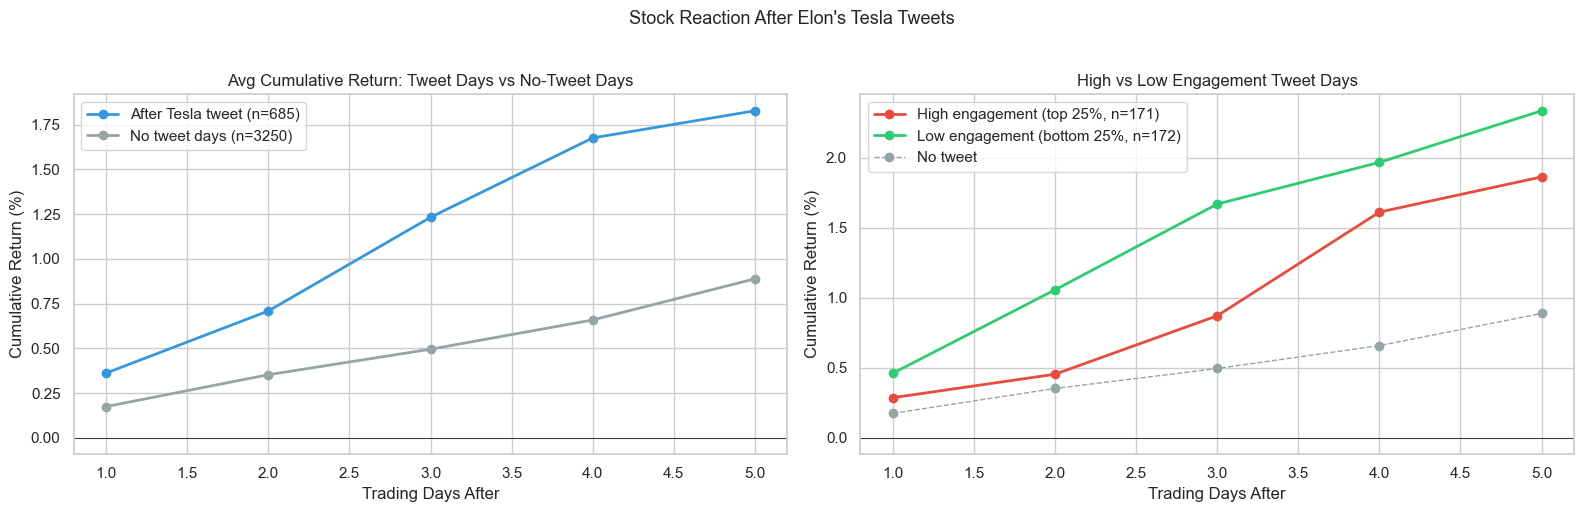

Day+1 avg return after tweet:       +0.362%
Day+1 avg return (no tweet):         +0.175%
Day+1 avg return (high engagement):  +0.287%
Day+1 avg return (low engagement):   +0.461%


In [12]:
# Event study: cumulative returns after Tesla tweets
returns = tsla['daily_return'].copy()
tweet_dates = tesla_originals.groupby('date').size().rename_axis('Date')
tweet_dates = tweet_dates[tweet_dates.index.isin(tsla.index)]  # only trading days

# Also get engagement for each tweet day
tweet_eng = tesla_originals.groupby('date').agg(
    total_likes=('likeCount', 'sum'),
    max_likes=('likeCount', 'max'),
    tweet_count=('fullText', 'count'),
).rename_axis('Date')
tweet_eng = tweet_eng[tweet_eng.index.isin(tsla.index)]

# Split into high-engagement vs low-engagement tweet days
median_likes = tweet_eng['total_likes'].median()
high_eng_dates = tweet_eng[tweet_eng['total_likes'] > tweet_eng['total_likes'].quantile(0.75)].index
low_eng_dates = tweet_eng[tweet_eng['total_likes'] <= tweet_eng['total_likes'].quantile(0.25)].index

# Non-tweet trading days for comparison
no_tweet_dates = tsla.index[~tsla.index.isin(tweet_dates.index)]

def cumulative_returns(event_dates, returns_series, window=5):
    """Calculate average cumulative returns after event dates."""
    cum_rets = []
    for d in event_dates:
        loc = returns_series.index.get_loc(d) if d in returns_series.index else None
        if loc is None or loc + window >= len(returns_series):
            continue
        chunk = returns_series.iloc[loc+1:loc+window+1].values
        cum_rets.append(np.cumsum(chunk))
    if cum_rets:
        return np.array(cum_rets).mean(axis=0)
    return np.zeros(window)

window = 5
all_tweet_cum = cumulative_returns(tweet_dates.index, returns, window)
high_eng_cum = cumulative_returns(high_eng_dates, returns, window)
low_eng_cum = cumulative_returns(low_eng_dates, returns, window)
no_tweet_cum = cumulative_returns(no_tweet_dates, returns, window)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

days = range(1, window + 1)
axes[0].plot(days, all_tweet_cum * 100, 'o-', color='#3498db', label=f'After Tesla tweet (n={len(tweet_dates)})', linewidth=2)
axes[0].plot(days, no_tweet_cum * 100, 'o-', color='#95a5a6', label=f'No tweet days (n={len(no_tweet_dates)})', linewidth=2)
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].set_xlabel('Trading Days After')
axes[0].set_ylabel('Cumulative Return (%)')
axes[0].set_title('Avg Cumulative Return: Tweet Days vs No-Tweet Days')
axes[0].legend()

axes[1].plot(days, high_eng_cum * 100, 'o-', color='#e74c3c', label=f'High engagement (top 25%, n={len(high_eng_dates)})', linewidth=2)
axes[1].plot(days, low_eng_cum * 100, 'o-', color='#2ecc71', label=f'Low engagement (bottom 25%, n={len(low_eng_dates)})', linewidth=2)
axes[1].plot(days, no_tweet_cum * 100, 'o--', color='#95a5a6', label='No tweet', linewidth=1)
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].set_xlabel('Trading Days After')
axes[1].set_ylabel('Cumulative Return (%)')
axes[1].set_title('High vs Low Engagement Tweet Days')
axes[1].legend()

plt.suptitle('Stock Reaction After Elon\'s Tesla Tweets', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

print(f'Day+1 avg return after tweet:       {all_tweet_cum[0]*100:+.3f}%')
print(f'Day+1 avg return (no tweet):         {no_tweet_cum[0]*100:+.3f}%')
print(f'Day+1 avg return (high engagement):  {high_eng_cum[0]*100:+.3f}%')
print(f'Day+1 avg return (low engagement):   {low_eng_cum[0]*100:+.3f}%')

## 7. Tweet Frequency Regimes

Hypothesis: shifts in Elon's tweeting frequency signal regime changes.  
Going from quiet to active (or vice versa) might matter more than the tweets themselves.

=== P(Up) by Overall Tweet Frequency (7-day) ===
  Q1 (quiet)     : P(Up) = 0.507  (n=983, tweets/7d: 0-3)
  Q2             : P(Up) = 0.513  (n=982, tweets/7d: 3-8)
  Q3             : P(Up) = 0.521  (n=982, tweets/7d: 8-17)
  Q4 (active)    : P(Up) = 0.523  (n=982, tweets/7d: 17-350)

=== P(Up) by Tweet Frequency Change (accelerating vs decelerating) ===
  Big decrease      : P(Up) = 0.514  (n=463)
  Small decrease    : P(Up) = 0.529  (n=688)
  Stable            : P(Up) = 0.509  (n=1725)
  Small increase    : P(Up) = 0.515  (n=643)
  Big increase      : P(Up) = 0.526  (n=403)

=== P(Up) by Tesla Tweet Ratio (% of tweets about Tesla) ===
  0% (no Tesla)     : P(Up) = 0.506  (n=867)
  1-5%              : P(Up) = 0.490  (n=294)
  5-15%             : P(Up) = 0.531  (n=637)
  >15%              : P(Up) = 0.525  (n=1473)


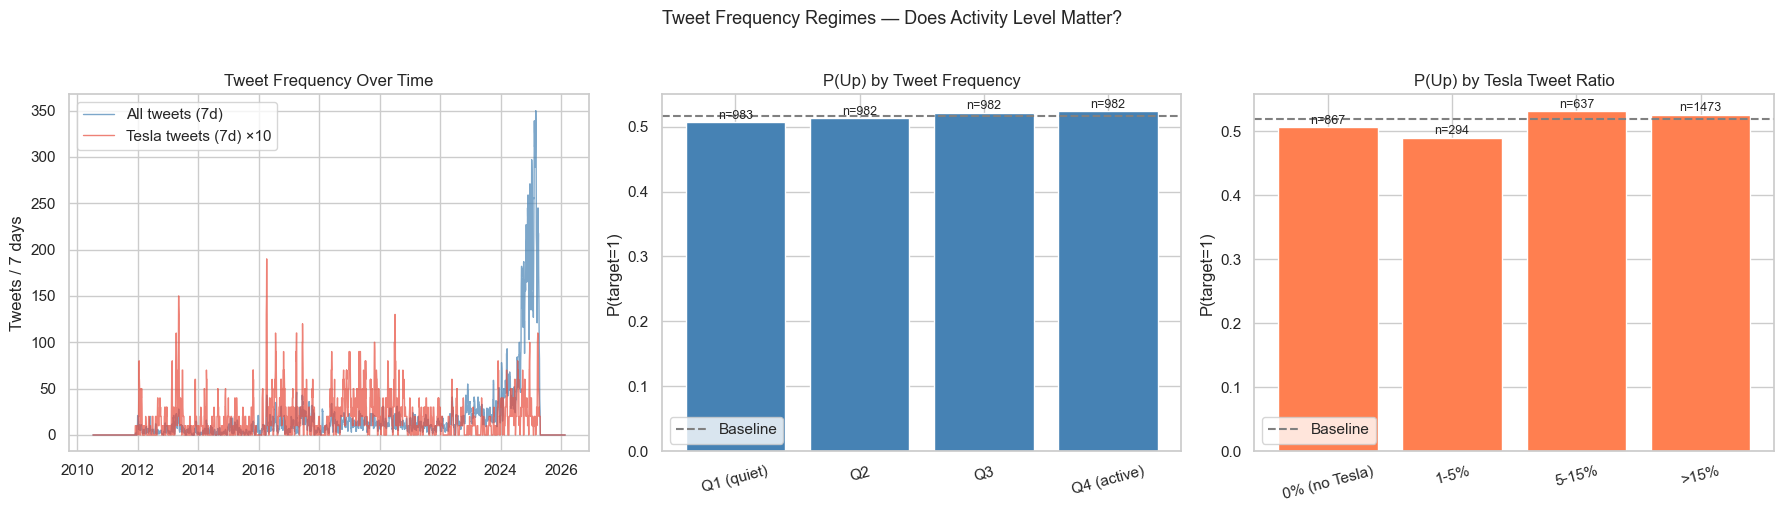

In [13]:
# Use ALL tweets (not just Tesla) — Elon's overall activity level
freq = tsla[['target', 'daily_return', 'next_day_return', 'Close']].copy()
freq = freq.join(all_daily, how='left').join(tesla_daily, how='left')
freq['all_tweet_count'] = freq['all_tweet_count'].fillna(0)
freq['tesla_tweet_count'] = freq['tesla_tweet_count'].fillna(0)

# Rolling frequency windows
freq['all_7d'] = freq['all_tweet_count'].rolling(7).sum()
freq['all_30d'] = freq['all_tweet_count'].rolling(30).sum()
freq['tesla_7d'] = freq['tesla_tweet_count'].rolling(7).sum()

# Frequency change (momentum in tweeting)
freq['all_7d_change'] = freq['all_7d'].diff(7)  # week-over-week change
freq['tesla_ratio'] = freq['tesla_7d'] / freq['all_7d'].clip(lower=1)  # % of tweets about Tesla

valid = freq.dropna(subset=['all_7d', 'target']).copy()

# Frequency quartiles (rank-based to avoid duplicate bin edges)
print('=== P(Up) by Overall Tweet Frequency (7-day) ===')
valid['freq_rank'] = valid['all_7d'].rank(method='first')
valid['freq_q'] = pd.qcut(valid['freq_rank'], q=4, labels=['Q1 (quiet)', 'Q2', 'Q3', 'Q4 (active)'])
for q in ['Q1 (quiet)', 'Q2', 'Q3', 'Q4 (active)']:
    sub = valid[valid['freq_q'] == q]
    print(f'  {q:15s}: P(Up) = {sub["target"].mean():.3f}  (n={len(sub)}, tweets/7d: {sub["all_7d"].min():.0f}-{sub["all_7d"].max():.0f})')
print()

# Frequency momentum
print('=== P(Up) by Tweet Frequency Change (accelerating vs decelerating) ===')
valid2 = valid.dropna(subset=['all_7d_change']).copy()
valid2['accel'] = pd.cut(valid2['all_7d_change'], bins=[-999, -10, -3, 3, 10, 999],
                          labels=['Big decrease', 'Small decrease', 'Stable', 'Small increase', 'Big increase'])
for label in ['Big decrease', 'Small decrease', 'Stable', 'Small increase', 'Big increase']:
    sub = valid2[valid2['accel'] == label]
    if len(sub) > 20:
        print(f'  {label:18s}: P(Up) = {sub["target"].mean():.3f}  (n={len(sub)})')
print()

# Tesla tweet ratio
print('=== P(Up) by Tesla Tweet Ratio (% of tweets about Tesla) ===')
valid3 = valid[valid['all_7d'] > 0].copy()
valid3['ratio_bucket'] = pd.cut(valid3['tesla_ratio'], bins=[-0.01, 0, 0.05, 0.15, 1.01],
                                 labels=['0% (no Tesla)', '1-5%', '5-15%', '>15%'])
for label in ['0% (no Tesla)', '1-5%', '5-15%', '>15%']:
    sub = valid3[valid3['ratio_bucket'] == label]
    if len(sub) > 20:
        print(f'  {label:18s}: P(Up) = {sub["target"].mean():.3f}  (n={len(sub)})')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Tweet frequency over time (all vs Tesla)
axes[0].plot(freq.index, freq['all_7d'], color='steelblue', alpha=0.7, linewidth=1, label='All tweets (7d)')
axes[0].plot(freq.index, freq['tesla_7d'] * 10, color='#e74c3c', alpha=0.7, linewidth=1, label='Tesla tweets (7d) ×10')
axes[0].set_title('Tweet Frequency Over Time')
axes[0].set_ylabel('Tweets / 7 days')
axes[0].legend()

# 2. P(Up) by frequency quartile
freq_rates = valid.groupby('freq_q', observed=True)['target'].agg(['mean', 'count'])
bars = axes[1].bar(range(len(freq_rates)), freq_rates['mean'], color='steelblue')
for i, (bar, n) in enumerate(zip(bars, freq_rates['count'])):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'n={int(n)}', ha='center', fontsize=9)
axes[1].set_xticks(range(len(freq_rates)))
axes[1].set_xticklabels(freq_rates.index, rotation=15)
axes[1].axhline(valid['target'].mean(), ls='--', color='gray', label='Baseline')
axes[1].set_title('P(Up) by Tweet Frequency')
axes[1].set_ylabel('P(target=1)')
axes[1].legend()

# 3. Tesla tweet ratio vs P(Up)
ratio_rates = valid3.groupby('ratio_bucket', observed=True)['target'].agg(['mean', 'count'])
bars = axes[2].bar(range(len(ratio_rates)), ratio_rates['mean'], color='coral')
for i, (bar, n) in enumerate(zip(bars, ratio_rates['count'])):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'n={int(n)}', ha='center', fontsize=9)
axes[2].set_xticks(range(len(ratio_rates)))
axes[2].set_xticklabels(ratio_rates.index, rotation=15)
axes[2].axhline(valid3['target'].mean(), ls='--', color='gray', label='Baseline')
axes[2].set_title('P(Up) by Tesla Tweet Ratio')
axes[2].set_ylabel('P(target=1)')
axes[2].legend()

plt.suptitle('Tweet Frequency Regimes — Does Activity Level Matter?', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## 8. Summary — What Works?

Collect all findings into a summary comparison.

In [14]:
baseline = tsla['target'].mean()

print('=' * 70)
print('TWEET SIGNAL EXPLORATION — SUMMARY')
print('=' * 70)
print(f'Baseline P(Up): {baseline:.3f}')
print()
print('Approach                          | Best signal              | P(Up)  | Delta  | n')
print('-' * 95)

# Collect all results
results = []

# 1. Engagement
for q in ['Q1 (low)', 'Q4 (viral)']:
    sub = tweet_days[tweet_days['likes_pct'] == q]
    if len(sub) > 0:
        p = sub['target'].mean()
        results.append(('Engagement (likes)', f'{q}', p, p - baseline, len(sub)))

# 2. Silence
for label in labels:
    sub = valid[valid['silence_bucket'] == label] if 'silence_bucket' in valid.columns else pd.DataFrame()
    if len(sub) > 10:
        p = sub['target'].mean()
        if abs(p - baseline) > 0.015:
            results.append(('Silence', label, p, p - baseline, len(sub)))

# 3. Timing
for session in sessions_order:
    if session in timing.columns:
        sub = timing[timing[session] > 0]
        if len(sub) > 10:
            p = sub['target'].mean()
            if abs(p - baseline) > 0.015:
                results.append(('Timing', session, p, p - baseline, len(sub)))

# 4. Topics
for topic in tesla_topics['primary_topic'].value_counts().index:
    sub = topic_merged[topic_merged['primary_topic'] == topic]
    if len(sub) >= 10:
        p = sub['target'].mean()
        if abs(p - baseline) > 0.015:
            results.append(('Topic', topic, p, p - baseline, len(sub)))

# 5. Frequency
for q in ['Q1 (quiet)', 'Q4 (active)']:
    sub = valid[valid['freq_q'] == q] if 'freq_q' in valid.columns else pd.DataFrame()
    if len(sub) > 0:
        p = sub['target'].mean()
        results.append(('Frequency', q, p, p - baseline, len(sub)))

# Sort by absolute delta
results.sort(key=lambda x: abs(x[3]), reverse=True)

for approach, signal, p_up, delta, n in results:
    marker = '***' if abs(delta) > 0.04 else '** ' if abs(delta) > 0.025 else '*  ' if abs(delta) > 0.015 else '   '
    print(f'{marker} {approach:30s} | {signal:24s} | {p_up:.3f} | {delta:+.3f} | {n}')

print()
print('Legend: *** strong (>4%), ** moderate (>2.5%), * weak (>1.5%)')
print()
print('NOTE: All comparisons are observational, not causal. Small sample sizes')
print('(n<100) should be treated with skepticism. Statistical significance not tested.')

TWEET SIGNAL EXPLORATION — SUMMARY
Baseline P(Up): 0.516

Approach                          | Best signal              | P(Up)  | Delta  | n
-----------------------------------------------------------------------------------------------
*** Topic                          | financial                | 0.667 | +0.151 | 27
*** Topic                          | production               | 0.400 | -0.116 | 50
*** Topic                          | energy                   | 0.444 | -0.071 | 63
*** Timing                         | overnight                | 0.570 | +0.054 | 79
*** Timing                         | market_hours             | 0.562 | +0.046 | 274
*** Timing                         | after_hours              | 0.558 | +0.042 | 208
*** Topic                          | ai_robot                 | 0.474 | -0.042 | 19
**  Engagement (likes)             | Q1 (low)                 | 0.552 | +0.037 | 172
**  Topic                          | general                  | 0.552 | +0.036 | 319
*  